# Testing different kernels for our GPs

In [32]:
import argparse
import itertools
import os
from typing import Dict, List, Tuple

import gpytorch
import numpy as np
import torch
import tqdm
from gpytorch.constraints import Interval
from sklearn.cluster import MiniBatchKMeans

In [73]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, input_dim, sequence_length=10):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
            jitter_val=1e-1,
        )
        super(GPModel, self).__init__(variational_strategy)

        # Use a positive constant mean as baseline for power values
        self.mean_module = gpytorch.means.ConstantMean()
        self.mean_module.constant.data.fill_(290.0)  # Start with a positive mean
        
        # Add constraints to ensure positive mean
        self.mean_module.constant.constraint = gpytorch.constraints.Positive()

        self.matern_kernel = gpytorch.kernels.MaternKernel(
            nu=0.5, ard_num_dims=input_dim,
            lengthscale_constraint=gpytorch.constraints.Interval(0.1, 250.0)
        )
        self.mixture_kernel = gpytorch.kernels.SpectralMixtureKernel(
            num_mixtures=4, ard_num_dims=input_dim
        )

        # Scale kernels to help with the magnitude of predictions
        self.covar_module = gpytorch.kernels.ScaleKernel(
            self.matern_kernel + self.mixture_kernel + self.matern_kernel,
            outputscale_constraint=gpytorch.constraints.Positive(initial_value=10.0)
        )

        self.sequence_length = sequence_length

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Return the distribution directly without transformation
        # since gpytorch doesn't have a transforms module
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [34]:
class PowerTraceDataset:
    def __init__(self, data_file: str):
        data = np.load(data_file)
        self.power_traces = data["power_traces"]
        self.prefill_tokens = data["prefill_tokens"]
        self.decode_tokens = data["decode_tokens"]
        self.poisson_rate = data["poisson_rate"]
        self.tensor_parallelism = data["tensor_parallelism"]
        self.model_size = data["model_sizes"]
        self.hardware = data["hardware"]
        self._store_data_ranges()
        self._normalize_data()
        self.grouped_data = self._group_data()

    def _store_data_ranges(self) -> None:
        self.data_ranges = {}

        for tp in np.unique(self.tensor_parallelism):
            mask = self.tensor_parallelism == tp
            self.data_ranges[f"power_{tp}"] = {
                "min": np.min(self.power_traces[mask]),
                "max": np.max(self.power_traces[mask]),
            }
        for tp in np.unique(self.tensor_parallelism):
            for ms in np.unique(self.model_size):
                mask = (self.tensor_parallelism == tp) & (self.model_size == ms)
                self.data_ranges[f"prefill_{tp}_{ms}"] = {
                    "min": np.min(self.prefill_tokens[mask]),
                    "max": np.max(self.prefill_tokens[mask]),
                }
                self.data_ranges[f"decode_{tp}_{ms}"] = {
                    "min": np.min(self.decode_tokens[mask]),
                    "max": np.max(self.decode_tokens[mask]),
                }

        self.data_ranges["poisson"] = {
            "min": np.min(self.poisson_rate),
            "max": np.max(self.poisson_rate),
        }
        self.data_ranges["tp"] = {
            "min": np.min(self.tensor_parallelism),
            "max": np.max(self.tensor_parallelism),
        }
        self.data_ranges["model_size"] = {
            "min": np.min(self.model_size),
            "max": np.max(self.model_size),
        }

    def _normalize_data(self) -> None:
        self.norm_power_traces = np.zeros_like(self.power_traces)
        self.norm_prefill = np.zeros_like(self.prefill_tokens)
        self.norm_decode = np.zeros_like(self.decode_tokens)
        self.norm_poisson = np.zeros_like(self.poisson_rate)
        self.norm_tp = np.zeros_like(self.tensor_parallelism)
        self.norm_model_size = np.zeros_like(self.model_size)
        self.norm_hardware = np.zeros_like(self.hardware, dtype=float)

        for tp in np.unique(self.tensor_parallelism):
            mask = self.tensor_parallelism == tp
            min_val = self.data_ranges[f"power_{tp}"]["min"]
            max_val = self.data_ranges[f"power_{tp}"]["max"]
            self.norm_power_traces[mask] = (self.power_traces[mask] - min_val) / (
                max_val - min_val
            )

        for tp in np.unique(self.tensor_parallelism):
            for ms in np.unique(self.model_size):
                mask = (self.tensor_parallelism == tp) & (self.model_size == ms)
                min_val = self.data_ranges[f"prefill_{tp}_{ms}"]["min"]
                max_val = self.data_ranges[f"prefill_{tp}_{ms}"]["max"]
                if max_val > min_val:
                    self.norm_prefill[mask] = (self.prefill_tokens[mask] - min_val) / (
                        max_val - min_val
                    )
                min_val = self.data_ranges[f"decode_{tp}_{ms}"]["min"]
                max_val = self.data_ranges[f"decode_{tp}_{ms}"]["max"]
                if max_val > min_val:
                    self.norm_decode[mask] = (self.decode_tokens[mask] - min_val) / (
                        max_val - min_val
                    )

        tp_min = self.data_ranges["tp"]["min"]
        tp_max = self.data_ranges["tp"]["max"]
        if tp_max > tp_min:
            self.norm_tp = (self.tensor_parallelism - tp_min) / (tp_max - tp_min)

        ms_min = self.data_ranges["model_size"]["min"]
        ms_max = self.data_ranges["model_size"]["max"]
        if ms_max > ms_min:
            self.norm_model_size = (self.model_size - ms_min) / (ms_max - ms_min)
        self.norm_poisson = self.poisson_rate

        for i, hw in enumerate(np.unique(self.hardware)):
            mask = self.hardware == hw
            self.norm_hardware[mask] = 0.0 if hw == "A100" else 1.0

    def _group_data(self) -> Dict[Tuple, Dict[str, np.ndarray]]:
        grouped_data = {}

        for tp, ms, hw in itertools.product(
            np.unique(self.tensor_parallelism),
            np.unique(self.model_size),
            np.unique(self.hardware),
        ):
            mask = (
                (self.tensor_parallelism == tp)
                & (self.model_size == ms)
                & (self.hardware == hw)
            )
            if not np.any(mask):
                continue
            grouped_data[(tp, ms, hw)] = {
                "power_traces": self.norm_power_traces[mask],
                "prefill_tokens": self.norm_prefill[mask],
                "decode_tokens": self.norm_decode[mask],
                "poisson_rate": self.norm_poisson[mask],
            }

        return grouped_data

    def _inducing_pts(self, X: torch.Tensor, m: int) -> torch.Tensor:
        if len(X) >= m:
            km = MiniBatchKMeans(n_clusters=m, n_init=1, random_state=0).fit(X.cpu())
            return torch.tensor(km.cluster_centers_, dtype=X.dtype, device=X.device)
        idx = torch.randperm(len(X))[:m]
        return X[idx]

    def get_inducing_points(self, tp: int, ms: float, hw: str, m: int) -> torch.Tensor:
        config = (tp, ms, hw)
        if config not in self.grouped_data:
            raise ValueError(f"No data available for configuration: {config}")
        config_data = self.grouped_data[config]
        n_samples = len(config_data["power_traces"])
        X = []

        for i in range(n_samples):
            sample_features = np.column_stack(
                [
                    config_data["prefill_tokens"][i],
                    config_data["decode_tokens"][i],
                    np.full_like(
                        config_data["prefill_tokens"][i], config_data["poisson_rate"][i]
                    ),
                ]
            )
            X.append(sample_features)
        X_tensor = torch.FloatTensor(np.vstack(X))
        return self._inducing_pts(X_tensor, m)

    def get_train_data(
        self, tp: int, ms: float, hw: str, sequence_length: int = 10, stride: int = 1
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        config = (tp, ms, hw)
        if config not in self.grouped_data:
            raise ValueError(f"No data available for configuration: {config}")

        config_data = self.grouped_data[config]
        n_samples = len(config_data["power_traces"])

        X_sequences = []
        y_sequences = []

        for i in range(n_samples):
            prefill = config_data["prefill_tokens"][i]
            decode = config_data["decode_tokens"][i]
            poisson = config_data["poisson_rate"][i]
            power = config_data["power_traces"][i]
            prefill_rate = np.gradient(prefill)
            decode_rate = np.gradient(decode)
            power_lag = np.pad(power[:-1], (1, 0), mode="edge")
            trace_length = len(power)

            for start in range(0, trace_length - sequence_length + 1, stride):
                end = start + sequence_length

                sequence_features = []
                for j in range(start, end):
                    rel_pos = (j - start) / sequence_length
                    time_step_features = [
                        prefill[j],  # Current prefill tokens
                        decode[j],  # Current decode tokens
                        prefill_rate[j],  # Rate of change in prefill
                        decode_rate[j],  # Rate of change in decode
                        power_lag[j],  # Previous power value
                        poisson,  # Poisson rate (constant)
                        rel_pos,  # Relative position in sequence
                    ]
                    sequence_features.append(time_step_features)

                X_sequences.append(sequence_features)
                y_sequences.append(power[start:end])

        X_tensor = torch.FloatTensor(np.array(X_sequences))
        y_tensor = torch.FloatTensor(np.array(y_sequences))

        return X_tensor, y_tensor

    def _prepare_temporal_features(self) -> None:
        self.temporal_features = {}

        for config, data in self.grouped_data.items():
            n_samples = len(data["power_traces"])

            prefill_rates = []
            decode_rates = []
            prefill_moving_avg = []
            decode_moving_avg = []
            power_lagged = []

            for i in range(n_samples):
                prefill_rate = np.gradient(data["prefill_tokens"][i])
                decode_rate = np.gradient(data["decode_tokens"][i])
                window = 5
                prefill_ma = np.convolve(
                    data["prefill_tokens"][i], np.ones(window) / window, mode="same"
                )
                decode_ma = np.convolve(
                    data["decode_tokens"][i], np.ones(window) / window, mode="same"
                )

                power_lag = np.pad(data["power_traces"][i][:-1], (1, 0), mode="edge")
                prefill_rates.append(prefill_rate)
                decode_rates.append(decode_rate)
                prefill_moving_avg.append(prefill_ma)
                decode_moving_avg.append(decode_ma)
                power_lagged.append(power_lag)

            self.temporal_features[config] = {
                "prefill_rates": prefill_rates,
                "decode_rates": decode_rates,
                "prefill_moving_avg": prefill_moving_avg,
                "decode_moving_avg": decode_moving_avg,
                "power_lagged": power_lagged,
            }

    def denormalize_power(self, norm_power: np.ndarray, tp: int, hw: str) -> np.ndarray:
        min_val = self.data_ranges[f"power_{tp}"]["min"]
        max_val = self.data_ranges[f"power_{tp}"]["max"]

        return norm_power * (max_val - min_val) + min_val

    def get_available_configs(self) -> List[Tuple]:
        return list(self.grouped_data.keys())

NotPSDError encountered, increased jitter to 1.0
NotPSDError encountered, increased jitter to 10.0
NotPSDError encountered, increased jitter to 100.0
NotPSDError encountered, increased jitter to 1000.0
Epoch 1/100, Loss: 16.3450
Epoch 2/100, Loss: 78.5474
Epoch 3/100, Loss: 73.4516
Epoch 4/100, Loss: 68.6302
Epoch 5/100, Loss: 64.0809
Epoch 6/100, Loss: 59.8006
Epoch 7/100, Loss: 55.7704
Epoch 8/100, Loss: 51.9590
Epoch 9/100, Loss: 48.3472
Epoch 10/100, Loss: 44.9115
Epoch 11/100, Loss: 41.6291
Epoch 12/100, Loss: 38.4560
Epoch 13/100, Loss: 35.3041
Epoch 14/100, Loss: 31.4791
Epoch 15/100, Loss: 29.4444
Epoch 16/100, Loss: 27.8468
Epoch 17/100, Loss: 25.8982
Epoch 18/100, Loss: 24.2191
Epoch 19/100, Loss: 23.3557
Epoch 20/100, Loss: 22.4387
Epoch 21/100, Loss: 21.7827
Epoch 22/100, Loss: 21.1681
Epoch 23/100, Loss: 20.6125
Epoch 24/100, Loss: 20.0935
Epoch 25/100, Loss: 19.6153
Epoch 26/100, Loss: 19.1822
Epoch 27/100, Loss: 18.8052
Epoch 28/100, Loss: 18.4784
Epoch 29/100, Loss: 18.

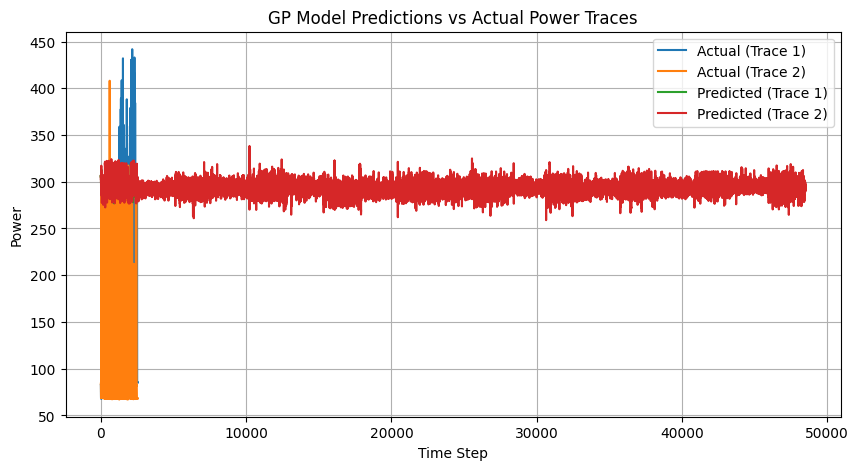

In [ ]:
import matplotlib.pyplot as plt
dataset = PowerTraceDataset("vllm-benchmark-llama-3-8b-power.npz")
power_trace_tp1 = dataset.power_traces[dataset.tensor_parallelism == 1]
prefill_tokens_tp1 = dataset.prefill_tokens[dataset.tensor_parallelism == 1]
decode_tokens_tp1 = dataset.decode_tokens[dataset.tensor_parallelism == 1]
# Select first and second traces
trace_idx = 0
trace_idx2 = 1  # Adding a second trace
power_trace = power_trace_tp1[trace_idx]
prefill_tokens = prefill_tokens_tp1[trace_idx] 
decode_tokens = decode_tokens_tp1[trace_idx]
power_trace2 = power_trace_tp1[trace_idx2]  # Second trace
prefill_tokens2 = prefill_tokens_tp1[trace_idx2]  # Second trace
decode_tokens2 = decode_tokens_tp1[trace_idx2]  # Second trace

# Create features for both traces
sequence_length = 5
n_samples = len(power_trace)
n_samples2 = len(power_trace2)
features = []

# Process first trace
for i in range(n_samples):
    if i < sequence_length:
        # Pad with zeros for first few samples
        seq_feats = np.zeros(sequence_length * 4)
    else:
        # Get sequence of features
        seq_feats = []
        for j in range(i-sequence_length+1, i+1):
            seq_feats.extend([
                prefill_tokens[j],
                decode_tokens[j],
                power_trace[j-1] if j > 0 else power_trace[0],
                1.0  # poisson rate
            ])
    features.append(seq_feats)

# Process second trace
for i in range(n_samples2):
    if i < sequence_length:
        # Pad with zeros for first few samples
        seq_feats = np.zeros(sequence_length * 4)
    else:
        # Get sequence of features
        seq_feats = []
        for j in range(i-sequence_length+1, i+1):
            seq_feats.extend([
                prefill_tokens2[j],
                decode_tokens2[j],
                power_trace2[j-1] if j > 0 else power_trace2[0],
                1.0  # poisson rate
            ])
    features.append(seq_feats)

# Combine power traces for training targets
combined_power_trace = np.concatenate([power_trace, power_trace2])

# Convert to tensors
train_x = torch.tensor(features, dtype=torch.float32)
train_y = torch.tensor(combined_power_trace, dtype=torch.float32)

# Initialize model
n_inducing = 250
inducing_points = train_x[:n_inducing].clone()
model = GPModel(inducing_points, train_x.shape[1], sequence_length=sequence_length)
likelihood = gpytorch.likelihoods.StudentTLikelihood(
    deg_free_constraint=Interval(2.0, 500.0)
)

# Training setup
model.train()
likelihood.train()
optimizer = torch.optim.Adam([
    {"params": model.parameters()},
    {"params": likelihood.parameters()}
], lr=0.01)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

# Training loop
n_epochs = 100
batch_size = 1024
train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
        try:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        except gpytorch.utils.errors.NotPSDError:
            # Increase jitter and retry
            model.variational_strategy.jitter_val *= 10
            print(f"NotPSDError encountered, increased jitter to {model.variational_strategy.jitter_val}")
            continue
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [761.0000,   0.0000,  68.2200,  ...,   0.0000,  68.2200,   1.0000],
        [761.0000,   0.0000,  68.2200,  ...,   0.0000,  68.2200,   1.0000],
        [761.0000,   0.0000,  68.2200,  ...,   0.0000,  68.2200,   1.0000]])


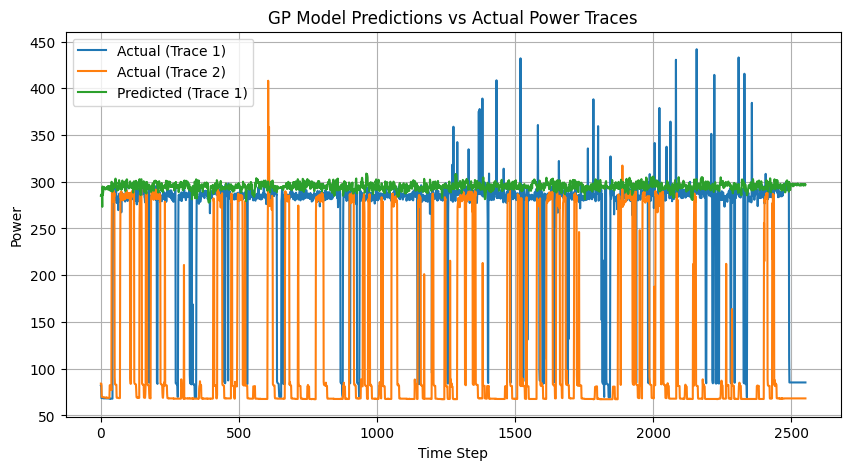

In [77]:
# Plot results
model.eval()
likelihood.eval()
print(train_x)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(train_x))
    mean = predictions.mean.numpy().flatten()  # Add .flatten()
    variance = predictions.variance.numpy().flatten()  # Add .flatten()
    lower = mean - 2 * np.sqrt(variance)
    upper = mean + 2 * np.sqrt(variance)
    
# clip mean to 50 to 400
mean = np.clip(mean, 50, 400)
plt.figure(figsize=(10,5))
plt.plot(power_trace, label='Actual (Trace 1)')
plt.plot(power_trace2, label='Actual (Trace 2)')
plt.plot(mean[:len(power_trace)], label='Predicted (Trace 1)')
plt.legend()
plt.title('GP Model Predictions vs Actual Power Traces')
plt.xlabel('Time Step')
plt.ylabel('Power')
plt.grid(True)
plt.show()